<a href="https://colab.research.google.com/github/jcorner1/MMH_Project/blob/main/Building_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Segmentation
https://github.com/fuzailpalnak/building-footprint-segmentation/blob/main/examples/Prediction.ipynb
https://github.com/satellite-image-deep-learning/techniques?tab=readme-ov-file#segmentation

In [1]:
! pip install building-footprint-segmentation

import os.path
import sys
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from imageio import imsave
from torch.utils import model_zoo

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from building_footprint_segmentation.seg.binary.models import ReFineNet
from building_footprint_segmentation.helpers.normalizer import min_max_image_net
from building_footprint_segmentation.utils.py_network import (
    to_input_image_tensor,
    add_extra_dimension,
    convert_tensor_to_numpy,
    load_parallel_model,
    adjust_model,
)
from building_footprint_segmentation.utils.operations import handle_image_size

In [2]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
MAX_SIZE = 384
TRAINED_MODEL = ReFineNet()
MODEL_URL = "https://github.com/fuzailpalnak/building-footprint-segmentation/releases/download/alpha/refine.zip"

PRED_PTH = r"path/to/input_image.png"

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 111MB/s]


In [4]:
def set_model_weights():
    state_dict = model_zoo.load_url(MODEL_URL, progress=True, map_location="cpu")
    if "model" in state_dict:
        state_dict = state_dict["model"]
    TRAINED_MODEL.load_state_dict(adjust_model(state_dict))


def extract(original_image):
    original_height, original_width = original_image.shape[:2]

    if (original_height, original_width) != (MAX_SIZE, MAX_SIZE):
        original_image = handle_image_size(original_image, (MAX_SIZE, MAX_SIZE))

    # Apply Normalization
    normalized_image = min_max_image_net(img=original_image)

    tensor_image = add_extra_dimension(to_input_image_tensor(normalized_image))

    with torch.no_grad():
        # Perform prediction
        prediction = TRAINED_MODEL(tensor_image)
        prediction = prediction.sigmoid()

    prediction_binary = convert_tensor_to_numpy(prediction[0]).reshape(
        (MAX_SIZE, MAX_SIZE)
    )

    prediction_3_channels = cv2.cvtColor(prediction_binary, cv2.COLOR_GRAY2RGB)

    dst = cv2.addWeighted(
        original_image,
        1,
        (prediction_3_channels * (0, 255, 0)).astype(np.uint8),
        0.4,
        0,
    )
    return prediction_binary, prediction_3_channels, dst

In [5]:
def run(image_path):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    set_model_weights()
    # PARALLELIZE the model if gpu available
    # model = load_parallel_model(model)

    prediction_binary, prediction_3_channels, dst = extract(original_image)
    # imsave(f"{os.path.basename(image_path)}", prediction_binary)
    return prediction_binary, prediction_3_channels, dst

In [6]:
from osgeo import gdal
import numpy as np
gdal.UseExceptions()

def load_sat_image(filename):
  """Loads a satellite image from a file.
  """

  # open the .sid file
  dataset = gdal.Open(filename)

  # get the raster bands
  band1 = dataset.GetRasterBand(1)
  band2 = dataset.GetRasterBand(2)
  band3 = dataset.GetRasterBand(3)

  # read the data as a numpy array
  data1 = band1.ReadAsArray()
  data2 = band2.ReadAsArray()
  data3 = band3.ReadAsArray()

  # create color image with the raster band arrays
  data = np.dstack((data1, data2, data3))
  return data

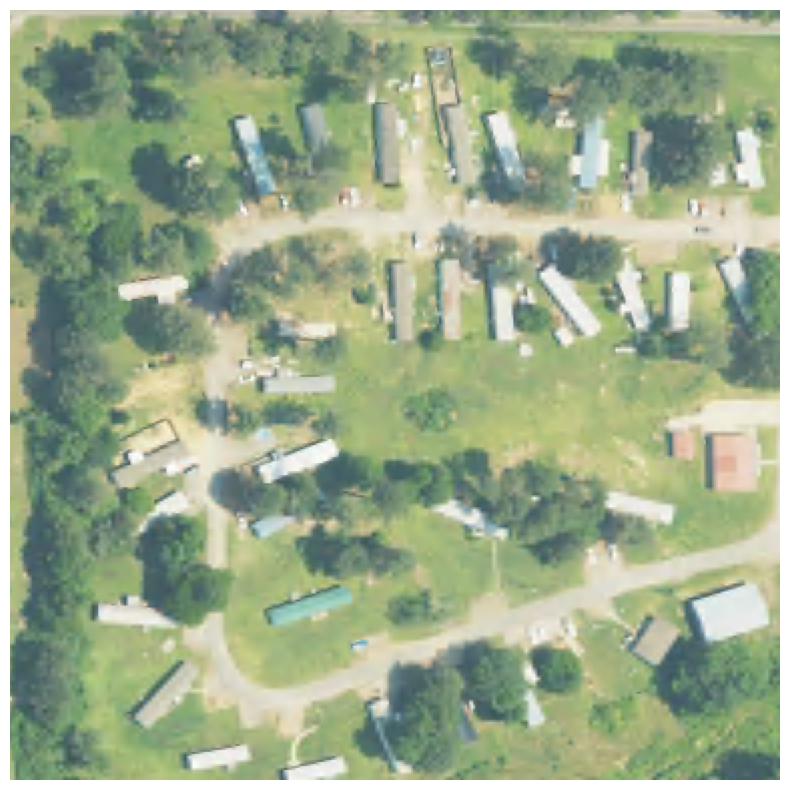

In [7]:
#
img = load_sat_image(f'/content/drive/My Drive/Colab Notebooks/subsets/tiles/ortho_1-1_hc_s_al127_2023_13.TIF')

#
mobile_home_img = img[3360:3744, 2416:2800]

#
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow((mobile_home_img).astype(np.uint8))
ax.axis("off")

# Save the image as a PNG
plt.imsave('/content/drive/My Drive/Colab Notebooks/Sat_Images/mobile_home_image.png',
           arr =  (mobile_home_img).astype(np.uint8), format='png')

Downloading: "https://github.com/fuzailpalnak/building-footprint-segmentation/releases/download/alpha/refine.zip" to /root/.cache/torch/hub/checkpoints/refine.zip
100%|██████████| 166M/166M [00:00<00:00, 247MB/s]
/usr/local/lib/python3.10/dist-packages/torch/hub.py:684: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


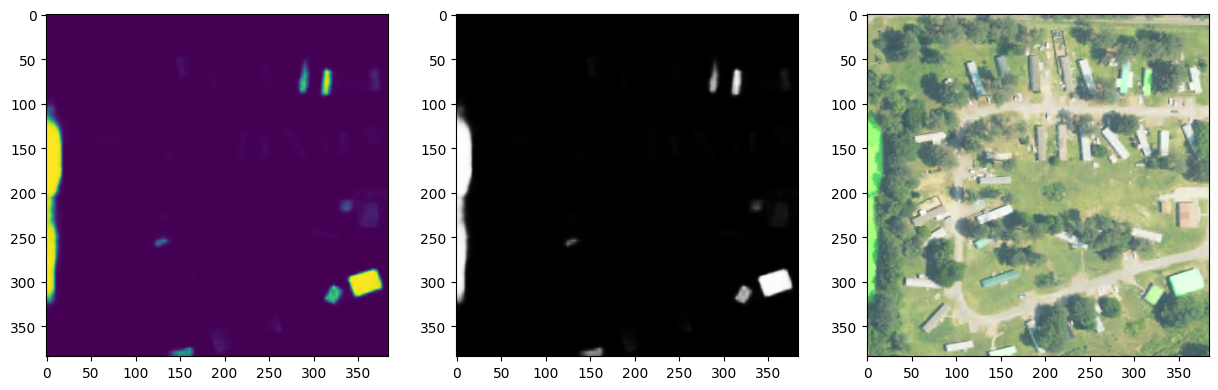

In [8]:
pred = run('/content/drive/My Drive/Colab Notebooks/Sat_Images/mobile_home_image.png')

fig,ax = plt.subplots(1,3,figsize = (15,15))
ax = ax.ravel()
for i in range(3):
  image = pred[i]
  ax[i].imshow(image)
plt.show()

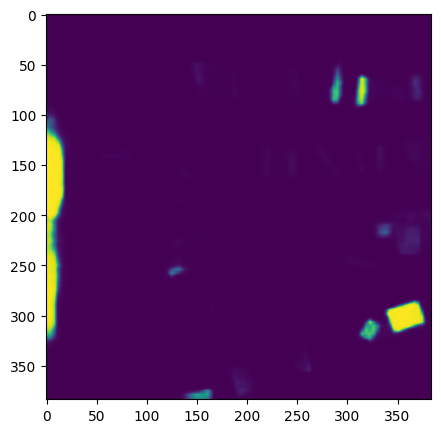

In [9]:
fig,ax = plt.subplots(1,1,figsize = (5,5))
ax.imshow(pred[0])

In [10]:
new_mask = pred[0]

In [11]:
# prompt: create a binary array of new_mask with any value over 5

binary_mask = (new_mask > 0.01).astype(int)


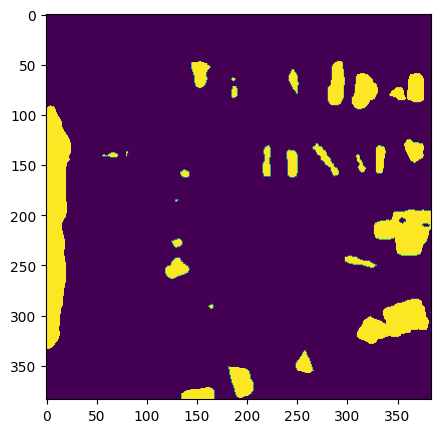

In [12]:
fig,ax = plt.subplots(1,1,figsize = (5,5))
ax.imshow(binary_mask)

In [ ]:
np.unique(binary_mask)

array([0])